In [1]:
import pandas as pd
import psycopg2
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) 
from sklearn import preprocessing
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
conn = psycopg2.connect(database="mid_term_project", user="lhl_student", password="lhl_student", host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com", port="5432")
print("Database opened successfully")

Database opened successfully


In [3]:
df = pd.read_sql_query('''SELECT * FROM flights ORDER BY random() LIMIT 10000;''', conn)

In [35]:
df.shape

(9808, 42)

In [5]:
df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-06-05,AA,AA,AA,2662,AA,N923AN,2662,11057,CLT,"Charlotte, NC",15370,TUL,"Tulsa, OK",1750,1748.0,-2.0,23.0,1811.0,1905.0,9.0,1906,1914.0,8.0,0.0,None,0.0,N,136.0,146.0,114.0,1.0,842.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2019-10-03,AA,AA_CODESHARE,AA,3358,MQ,N268NN,3358,11921,GJT,"Grand Junction, CO",11298,DFW,"Dallas/Fort Worth, TX",1043,1036.0,-7.0,10.0,1046.0,1348.0,6.0,1350,1354.0,4.0,0.0,None,0.0,N,127.0,138.0,122.0,1.0,773.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
2,2018-12-20,DL,DL_CODESHARE,DL,3575,OO,N926EV,3575,11577,ERI,"Erie, PA",11433,DTW,"Detroit, MI",618,958.0,220.0,15.0,1013.0,1047.0,16.0,739,1103.0,204.0,0.0,None,0.0,N,81.0,65.0,34.0,1.0,164.0,204.0,0.0,0.0,0.0,0.0,None,NaN,NaN,None
3,2018-04-24,F9,F9,F9,1456,F9,N207FR,1456,12889,LAS,"Las Vegas, NV",10397,ATL,"Atlanta, GA",5,2359.0,-6.0,16.0,15.0,638.0,7.0,656,645.0,-11.0,0.0,None,0.0,N,231.0,226.0,203.0,1.0,1747.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
4,2018-10-14,AA,AA,AA,1282,AA,N357PV,1282,11298,DFW,"Dallas/Fort Worth, TX",14683,SAT,"San Antonio, TX",1050,1051.0,1.0,12.0,1103.0,1148.0,4.0,1202,1152.0,-10.0,0.0,None,0.0,N,72.0,61.0,45.0,1.0,247.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None


In [75]:
df.cancelled.value_counts()
#df[df['cancelled']==1].head

0.0    9808
Name: cancelled, dtype: int64

In [48]:
#Dropping cancelled flights
df = df[df.diverted != 1.0]
df = df[df.cancelled != 1.0].reset_index(drop=True)

In [49]:
#Dropping null values
df = df[df.air_time.notna()].reset_index(drop=True)

In [50]:
df.dep_delay = df.dep_delay.fillna(0)
df.arr_delay = df.arr_delay.fillna(0)

In [51]:
#Checking null values
df1.isnull().sum()

fl_date                0
mkt_unique_carrier     0
mkt_carrier_fl_num     0
origin_airport_id      0
origin                 0
dest_airport_id        0
dest                   0
crs_dep_time           0
dep_time               0
dep_delay              0
crs_arr_time           0
arr_time               0
arr_delay              0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
distance               0
dtype: int64

In [67]:
df1 = df[['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin_airport_id', 'origin', 'dest_airport_id', 'dest', 'crs_dep_time',
         'dep_time', 'dep_delay', 'crs_arr_time', 'arr_time', 'arr_delay', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'distance']]

In [76]:
df1.shape

(9086, 21)

In [77]:
IQR = (df1['arr_delay'].quantile(0.85)-df1['arr_delay'].quantile(0.25))
lower_outlier = df1['arr_delay'].quantile(0.15) - 1.5*IQR
upper_outlier = df1['arr_delay'].quantile(0.85) + 1.5*IQR
print(lower_outlier, upper_outlier)

-59.0 50.0


<ipython-input-78-5907e1d982f7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[(df['arr_delay'] < upper_outlier) & (df1['arr_delay'] > lower_outlier)]


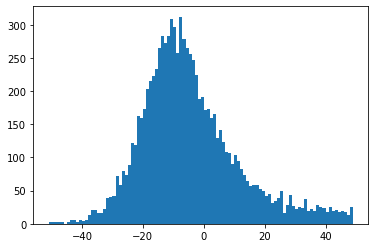

In [78]:
# get rid of outliers
df1 = df1[(df['arr_delay'] < upper_outlier) & (df1['arr_delay'] > lower_outlier)]
plt.hist(df1['arr_delay'], bins=100);

In [79]:
df1['dest'].value_counts()

ATL    472
ORD    466
DFW    315
LAX    306
DEN    296
      ... 
DUT      1
PSM      1
CGI      1
COD      1
USA      1
Name: dest, Length: 301, dtype: int64

In [80]:
# change flight date to datetime
df1['fl_date'] = pd.to_datetime(df1['fl_date'])
#df1.dtypes

In [81]:
# create year, month, day, dayofweek columns
df1['year'] = df1['fl_date'].dt.year
df1['month'] = df1['fl_date'].dt.month
df1['day'] = df1['fl_date'].dt.day
df1['dayofweek'] = df1['fl_date'].dt.dayofweek

In [20]:
#df1 = df1.dropna(axis=0, subset=['dep_time', 'arr_time'])

In [21]:
#df1['dep_time'] = df1['dep_time'].astype(int)
#df1['arr_time'] = df1['arr_time'].astype(int)
#df1['dep_time'] = df1['dep_time'].astype(str)
#df1['arr_time'] = df1['arr_time'].astype(str)

In [22]:
df1['crs_dep_time'] = df1['crs_dep_time'].astype(int)
df1['crs_arr_time'] = df1['crs_arr_time'].astype(int)
df1['crs_dep_time'] = df1['crs_dep_time'].astype(str)
df1['crs_arr_time'] = df1['crs_arr_time'].astype(str)

In [23]:
# create departure hour and arrival hour columns
#df1['dep_time'] = df1['dep_time'].apply(lambda x: str(x).zfill(4))
#df1['arr_time'] = df1['arr_time'].apply(lambda x: str(x).zfill(4))
#df1['dep_h'] = df1['dep_time'].str[0:2]
#df1['arr_h'] = df1['arr_time'].str[0:2]
#df1['dep_h'] = df1['dep_h'].replace('24', '00')
#df1['arr_h'] = df1['arr_h'].replace('24', '00')

In [32]:
# create departure hour and arrival hour columns
df1['crs_dep_time'] = df1['crs_dep_time'].apply(lambda x: str(x).zfill(4))
df1['crs_arr_time'] = df1['crs_arr_time'].apply(lambda x: str(x).zfill(4))
df1['dep_h'] = df1['crs_dep_time'].str[0:2]
df1['arr_h'] = df1['crs_arr_time'].str[0:2]
df1['dep_h'] = df1['dep_h'].replace('24', '00')
df1['arr_h'] = df1['arr_h'].replace('24', '00')

In [25]:
df1.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,year,month,day,dayofweek,dep_h,arr_h
0,2019-03-22,F9,546,10849,BZN,11292,DEN,1856,1842.0,-14.0,2040,2023.0,-17.0,104.0,101.0,77.0,524.0,2019,3,22,4,18,20
1,2018-02-18,AA,2735,11298,DFW,14524,RIC,1100,1054.0,-6.0,1445,1429.0,-16.0,165.0,155.0,134.0,1158.0,2018,2,18,6,11,14
2,2018-01-27,AA,397,13303,MIA,14843,SJU,1955,1957.0,2.0,2336,2337.0,1.0,161.0,160.0,134.0,1045.0,2018,1,27,5,19,23
3,2019-02-24,AA,231,12478,JFK,12889,LAS,2030,2030.0,0.0,2337,2347.0,10.0,367.0,377.0,341.0,2248.0,2019,2,24,6,20,23
4,2018-04-08,AA,1141,13930,ORD,14635,RSW,1215,1215.0,0.0,1608,1551.0,-17.0,173.0,156.0,134.0,1120.0,2018,4,8,6,12,16


In [26]:
# calculate mean delay based on carrier
carrier = df1.groupby('mkt_unique_carrier')['arr_delay'].mean().index.to_list()
mean_delay_carrier = df1.groupby('mkt_unique_carrier')['arr_delay'].mean().to_list()

In [27]:
# calculate mean delay based on origin of the flight
origin = df1.groupby('origin')['arr_delay'].mean().index.to_list()
mean_delay_origin = df1.groupby('origin')['arr_delay'].mean().to_list()

In [28]:
# calculate mean delay based on destination of the flight
dest = df1.groupby('dest')['arr_delay'].mean().index.to_list()
mean_delay_dest = df1.groupby('dest')['arr_delay'].mean().to_list()

In [29]:
# calculate mean delay based on month
month = df1.groupby('month')['arr_delay'].mean().index.to_list()
mean_delay_month = df1.groupby('month')['arr_delay'].mean().to_list()

In [30]:
# calculate mean delay based on scheduled departure hour
dep_hour = df1.groupby('dep_h')['arr_delay'].mean().index.to_list()
mean_delay_dep_h = df1.groupby('dep_h')['arr_delay'].mean().to_list()

# calculate mean delay based on scheduled arrival hour
arr_hour = df1.groupby('arr_h')['arr_delay'].mean().index.to_list()
mean_delay_arr_h = df1.groupby('arr_h')['arr_delay'].mean().to_list()

In [31]:
df_carrier_delays = pd.DataFrame({'carrier': carrier, 'mean_delay_carrier': mean_delay_carrier})
df_origin_delays = pd.DataFrame({'origin': origin, 'mean_delay_origin': mean_delay_origin})
df_dest_delays = pd.DataFrame({'dest': dest, 'mean_delay_dest': mean_delay_dest})
df_month_delays = pd.DataFrame({'month': month, 'mean_delay_month': mean_delay_month})
df_dep_h_delays = pd.DataFrame({'dep_h': dep_hour, 'mean_delay_dep_h': mean_delay_dep_h})
df_arr_h_delays = pd.DataFrame({'arr_h': arr_hour, 'mean_delay_arr_h': mean_delay_arr_h})

### Create a dataframe with columns from the test file

In [73]:
df_test = df1[['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', \
               'dest', 'crs_dep_time', 'dep_h', 'crs_arr_time', 'arr_h', 'crs_elapsed_time', 'distance', 'arr_delay']]

KeyError: "['dayofweek', 'year', 'dep_h', 'arr_h', 'day', 'month'] not in index"

In [33]:
df_test.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0


### Merge dataframes based on historical summary statistics

#### Add column for carrier delay

In [34]:
df_merged = df_test.merge(df_carrier_delays, how='left', left_on='mkt_unique_carrier' , right_on='carrier')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,carrier,mean_delay_carrier
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0,F9,-0.433824
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0,AA,-2.684211
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0,AA,-2.684211
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0,AA,-2.684211
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0,AA,-2.684211


In [35]:
df_merged = df_merged.drop(columns='carrier')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0,-0.433824
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0,-2.684211
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0,-2.684211
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0,-2.684211
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0,-2.684211


#### Add column for origin delay

In [36]:
df_merged = df_merged.merge(df_origin_delays, how='left', left_on='origin' , right_on='origin')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0,-0.433824,-16.111111
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0,-2.684211,0.317152
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0,-2.684211,-5.225490
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0,-2.684211,-3.404110
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0,-2.684211,-0.288136


#### Add column for destination delay

In [37]:
df_merged = df_merged.merge(df_dest_delays, how='left', left_on='dest' , right_on='dest')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0,-0.433824,-16.111111,-4.920354
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0,-2.684211,0.317152,1.675676
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0,-2.684211,-5.225490,0.066667
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0,-2.684211,-3.404110,-1.423423
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0,-2.684211,-0.288136,-2.527778


#### Add column for month delay

In [38]:
df_merged = df_merged.merge(df_month_delays, how='left', left_on='month' , right_on='month')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0,-0.433824,-16.111111,-4.920354,-2.987030
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0,-2.684211,0.317152,1.675676,-2.739663
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0,-2.684211,-5.225490,0.066667,-5.025352
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0,-2.684211,-3.404110,-1.423423,-2.739663
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0,-2.684211,-0.288136,-2.527778,-4.242627


#### Add column for depature hour delay

In [39]:
df_merged = df_merged.merge(df_dep_h_delays, how='left', left_on='dep_h' , right_on='dep_h')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month,mean_delay_dep_h
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0,-0.433824,-16.111111,-4.920354,-2.987030,-0.777336
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0,-2.684211,0.317152,1.675676,-2.739663,-3.309982
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0,-2.684211,-5.225490,0.066667,-5.025352,-0.680180
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0,-2.684211,-3.404110,-1.423423,-2.739663,-0.530000
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0,-2.684211,-0.288136,-2.527778,-4.242627,-3.790894


#### Add column for arrival hour delay

In [40]:
df_merged = df_merged.merge(df_arr_h_delays, how='left', left_on='arr_h' , right_on='arr_h')
df_merged.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,dep_h,crs_arr_time,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month,mean_delay_dep_h,mean_delay_arr_h
0,2019,3,22,4,F9,546,BZN,DEN,1856,18,2040,20,104.0,524.0,-17.0,-0.433824,-16.111111,-4.920354,-2.987030,-0.777336,0.262940
1,2018,2,18,6,AA,2735,DFW,RIC,1100,11,1445,14,165.0,1158.0,-16.0,-2.684211,0.317152,1.675676,-2.739663,-3.309982,-2.396429
2,2018,1,27,5,AA,397,MIA,SJU,1955,19,2336,23,161.0,1045.0,1.0,-2.684211,-5.225490,0.066667,-5.025352,-0.680180,-2.370546
3,2019,2,24,6,AA,231,JFK,LAS,2030,20,2337,23,367.0,2248.0,10.0,-2.684211,-3.404110,-1.423423,-2.739663,-0.530000,-2.370546
4,2018,4,8,6,AA,1141,ORD,RSW,1215,12,1608,16,173.0,1120.0,-17.0,-2.684211,-0.288136,-2.527778,-4.242627,-3.790894,-2.632812


In [41]:
data = df_merged.copy()

In [42]:
data = data.drop(columns=['crs_dep_time', 'crs_arr_time'])
data.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,dep_h,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month,mean_delay_dep_h,mean_delay_arr_h
0,2019,3,22,4,F9,546,BZN,DEN,18,20,104.0,524.0,-17.0,-0.433824,-16.111111,-4.920354,-2.987030,-0.777336,0.262940
1,2018,2,18,6,AA,2735,DFW,RIC,11,14,165.0,1158.0,-16.0,-2.684211,0.317152,1.675676,-2.739663,-3.309982,-2.396429
2,2018,1,27,5,AA,397,MIA,SJU,19,23,161.0,1045.0,1.0,-2.684211,-5.225490,0.066667,-5.025352,-0.680180,-2.370546
3,2019,2,24,6,AA,231,JFK,LAS,20,23,367.0,2248.0,10.0,-2.684211,-3.404110,-1.423423,-2.739663,-0.530000,-2.370546
4,2018,4,8,6,AA,1141,ORD,RSW,12,16,173.0,1120.0,-17.0,-2.684211,-0.288136,-2.527778,-4.242627,-3.790894,-2.632812


In [16]:
data.shape

(9264, 16)

In [15]:
data = df1.drop(columns=['fl_date']).copy()

In [21]:
data

,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance
0,0,2662,11057,63,15370,289,1750,1748.0,-2.0,1906,1914.0,8.0,136.0,146.0,114.0,842.0
1,0,3358,11921,122,11298,77,1043,1036.0,-7.0,1350,1354.0,4.0,127.0,138.0,122.0,773.0
3,4,1456,12889,172,10397,16,5,2359.0,-6.0,656,645.0,-11.0,231.0,226.0,203.0,1747.0
4,0,1282,11298,82,14683,251,1050,1051.0,1.0,1202,1152.0,-10.0,72.0,61.0,45.0,247.0
7,3,4243,14869,286,15389,292,2225,2220.0,-5.0,2320,2256.0,-24.0,55.0,36.0,27.0,175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,0,2149,10721,38,11278,75,1700,1655.0,-5.0,1849,1831.0,-18.0,109.0,96.0,73.0,399.0
9804,8,5239,14771,278,14689,253,1617,1615.0,-2.0,1737,1749.0,12.0,80.0,94.0,50.0,262.0
9805,3,2842,11433,89,14492,239,710,704.0,-6.0,856,838.0,-18.0,106.0,94.0,74.0,501.0
9806,10,3364,12191,141,14107,222,1050,1108.0,18.0,1135,1131.0,-4.0,165.0,143.0,130.0,1020.0


In [81]:
data['dep_h'] = data['dep_h'].astype(int)
data['arr_h'] = data['arr_h'].astype(int)
data.dtypes

KeyError: 'dep_h'

In [17]:
# function to label encode desired columns
def label_encode(df, cols):
    le = preprocessing.LabelEncoder()
    for i in cols:
        df[i] = le.fit_transform(df[i].values)
    return df

In [18]:
# define columns to encode
cols_to_encode = ['mkt_unique_carrier', 'origin', 'dest']
data = label_encode(data, cols_to_encode)
data.dtypes

mkt_unique_carrier       int64
mkt_carrier_fl_num       int64
origin_airport_id        int64
origin                   int64
dest_airport_id          int64
dest                     int64
crs_dep_time             int64
dep_time               float64
dep_delay              float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
distance               float64
dtype: object

In [85]:
data.to_csv('test_data.csv')

In [19]:
scaler = preprocessing.StandardScaler()
X = data.drop(columns='arr_delay').values
y = data['arr_delay'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Standardize the data using only statistics from the training set
# (always assume no knowledge of the test set for most unbiased performance estimate)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
reg = LinearRegression()
k_folds = 5

# Cross-validation
cv_r2 = cross_val_score(reg, X_train, y_train, cv=k_folds, scoring='r2')

# Train model on the entire training set
reg.fit(X_train, y_train)

# Test the model
y_pred_linreg = reg.predict(X_test)

# Calculate metrics
r2_linreg = r2_score(y_test, y_pred_linreg)
rmse_linreg = mean_squared_error(y_test, y_pred_linreg, squared=False)

# Compare traing to test accuracy
linreg_training_accuracy = reg.score(X_train, y_train)
linreg_test_accuracy = reg.score(X_test, y_test)

# Print results
print('Linear Regression')
print('==================')
print(f'Cross-validated R^2\nMean: {cv_r2.mean():.4f}\nStd.: {cv_r2.std():.4f}')
print(f'R^2: {r2_linreg:.4f}')
print(f'RMSE: {rmse_linreg:.4f}')
print(f'Training accuracy: {linreg_training_accuracy:.4f}')
print(f'Test accuracy: {linreg_test_accuracy:.4f}')

Linear Regression
Cross-validated R^2
Mean: 1.0000
Std.: 0.0000
R^2: 1.0000
RMSE: 0.0000
Training accuracy: 1.0000
Test accuracy: 1.0000


In [89]:
# Create polynomial feature set and train model
Xpoly_train = PolynomialFeatures(degree=2).fit_transform(X_train)
Xpoly_test = PolynomialFeatures(degree=2).fit_transform(X_test)

# Train and test the model
reg.fit(Xpoly_train, y_train)
ypoly_train_pred = reg.predict(Xpoly_train)
ypoly_test_pred = reg.predict(Xpoly_test)

# Calculate metrics
r2_polyreg = r2_score(y_test, ypoly_test_pred)
rmse_polyreg = mean_squared_error(y_test, ypoly_test_pred, squared=False)

# Check performance on train and test set
r2poly_train = r2_score(y_train, ypoly_train_pred)
r2poly_test = r2_score(y_test, ypoly_test_pred)

# Print results
print('Linear Regression with Polynomial Degree = 2')
print('============================================')
print(f'Number of polynomial features: {Xpoly_train.shape[1]}')
print(f'R^2: {r2_polyreg:.4f}')
print(f'RMSE: {rmse_polyreg:.4f}')
print(f'Training accuracy: {r2poly_train:.4f}\nTest accuracy: {r2poly_test:.4f}')

Linear Regression with Polynomial Degree = 2
Number of polynomial features: 136
R^2: 1.0000
RMSE: 0.0000
Training accuracy: 1.0000
Test accuracy: 1.0000


In [90]:
# define hyperparameters
param_grid = {'alpha': [0.1, 1, 5, 10]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_r2_rr = grid_result.best_score_  
best_alpha_rr = grid_result.best_params_['alpha']
best_rr_model = grid_result.best_estimator_ 

# Predict results
y_pred_rr = best_rr_model.predict(X_test)

# Calculate metrics
r2_test_rr = r2_score(y_test, y_pred_rr)
rmse_rr = mean_squared_error(y_test, y_pred_rr, squared=False)

# Check training and test accuracy
rr_training_accuracy = best_rr_model.score(X_train, y_train)
rr_test_accuracy = best_rr_model.score(X_test, y_test)

# Print results
print('Ridge Regression')
print('================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_rr:.4f}\nAlpha:\t{best_alpha_rr}')
print(f'R^2: {r2_test_rr:.4f}')
print(f'RMSE:  {rmse_rr:.4f}')
print(f'Training accuracy: {rr_training_accuracy:.4f},    Test accuracy: {rr_test_accuracy:.4f}')

Ridge Regression
The best hyperparameter settings achieve a cross-validated R^2 of: 1.0000
Alpha:	0.1
R^2: 1.0000
RMSE:  0.0138
Training accuracy: 1.0000,    Test accuracy: 1.0000


In [57]:
# define hyperparameters
param_grid = {'alpha': [50000, 60000, 80000, 100000]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(Xpoly3_train, y_train)

# Check best hyperparameters and train the best model
best_r2_poly = grid_result.best_score_   
best_alpha_poly = grid_result.best_params_['alpha']
best_rr_poly = grid_result.best_estimator_

# Predict results
y_pred_poly = best_rr_poly.predict(Xpoly3_test)

# Calculate metrics
r2_test_poly = r2_score(y_test, y_pred_poly)
rmse_rr_poly = mean_squared_error(y_test, y_pred_poly, squared=False)

# Check training and test accuracy
rr_poly_training_accuracy = best_rr_poly.score(Xpoly3_train, y_train)
rr_poly_test_accuracy = best_rr_poly.score(Xpoly3_test, y_test)

# Print results
print('Ridge Regresssion on Polynomial (Degree = 3) with grid search')
print('=============================================================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_poly:.4f}\nAlpha:\t{best_alpha_poly}')
print(f'R^2 :{r2_test_poly:.4f}')
print(f'RMSE:  {rmse_rr_poly:.4f}')
print(f'Training accuracy: {rr_poly_training_accuracy:.4f},    Test accuracy: {rr_poly_test_accuracy:.4f}')

Ridge Regresssion on Polynomial (Degree = 3) with grid search
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0296
Alpha:	50000
R^2 :0.0786
RMSE:  19.0521
Training accuracy: 0.1197,    Test accuracy: 0.0786
